## Implementation from scratch of a simple Naive Bayes classifier

Problem: given a class $K$ and a set of observed data about an item $x$, estimate

$$
P(K=1 \mid x ),
$$

where $K=1$ means that $x$ is an item of the class $K$.

Note that:
$$
P(K = 1 \mid x) = \frac{P(K=1)P(x \mid K=1)}{P(x)} \approx P(K=1)P(x \mid K=1)
$$

$$
P(K = 1 \mid x) \approx P(K=1) \prod\limits_{i=0}^{N}P(x_i \mid K=1)
$$

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [4]:
from sklearn.model_selection import train_test_split

In [49]:
from collections import defaultdict, Counter

In [138]:
T = pd.read_csv('./data/zoo/zoo.csv')
C = pd.read_csv('./data/zoo/class.csv')

## Progettazione
- *Pre-processing dei dati*
- *Split train e test set*
- Training (fit)
- Test (prediction)
- Evaluate

In [125]:
class Dataset(object):
    
    def __init__(self, dataframe: pd.DataFrame):
        self.df = dataframe
        self.classes = None
        
    def onehot(self, variable, prefix):
        oneh = pd.get_dummies(self.df[variable], prefix=prefix)
        df = self.df[[x for x in self.df.columns if x != variable]]
        self.df = df.join(oneh)
    
    def clean(self, variable):
        self.df = self.df[[x for x in self.df.columns if x != variable]]
    
    def features_class(self, variable):
        self.classes = self.df[variable].values
        self.clean(variable)
    
    def train_test_split(self, test_size=0.3):
        return train_test_split(self.df, self.classes, test_size=test_size, random_state=42)

    
class Classifier(object):
    
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
        self.priors = defaultdict(lambda: 0)
        self.likelihoods = pd.DataFrame(defaultdict(lambda: defaultdict(lambda: 0)))
        
    def _get_prior(self):
        self.priors = dict([(x, y / self.y.shape[0]) for x, y in Counter(self.y).most_common()])
    
    def _split_by_class(self, class_index):
        indexes = [i for i, x in enumerate(self.y) if x == class_index]
        return self.X.iloc[indexes]
    
    def _likelihood(self, class_index):
        split = self._split_by_class(class_index)
        return (split.sum(axis=0) + 1) / (split.shape[0] + 1)
    
    def _matrix_likelihood(self):
        self.likelihoods = pd.DataFrame(
            [self._likelihood(i) for i in list(self.priors.keys())], 
            index=list(self.priors.keys())).T
    
    def fit(self):
        self._get_prior()
        self._matrix_likelihood()
        
    def get_prior(self, class_index):
        return self.priors[class_index]
    
    def get_likelihood(self, class_index, feature):
        return self.likelihoods.loc[feature][class_index]
    
    def predict(self, data: pd.DataFrame):
        y_hat, list_classes = [], sorted(K.priors.keys())
        features = [[k for k, v in row.items() if v == 1] for i, row in data.iterrows()]
        for item in features:
            class_predictions = []
            for classindex in list_classes:
                pred = np.prod([self.get_likelihood(classindex, x) for x in item]) * self.get_prior(classindex)
                class_predictions.append(pred)
            prediction_index = np.argmax(class_predictions)
            y_hat.append(list_classes[prediction_index])
        return y_hat
            

In [126]:
zoo = Dataset(dataframe=T)
zoo.onehot('legs', prefix='legs')
zoo.clean('animal_name')
zoo.features_class('class_type')
X_train, X_test, y_train, y_test = zoo.train_test_split(test_size=0.25)

In [127]:
K = Classifier(X_train, y_train)
K.fit()

In [128]:
y_pred = K.predict(X_test)

## Evaluation
True Positive, False Positive, False Negative, True Negative

In [146]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [147]:
import matplotlib.pyplot as plt

In [149]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      0.50      0.67         2

    accuracy                           0.92        26
   macro avg       0.79      0.79      0.76        26
weighted avg       0.92      0.92      0.91        26



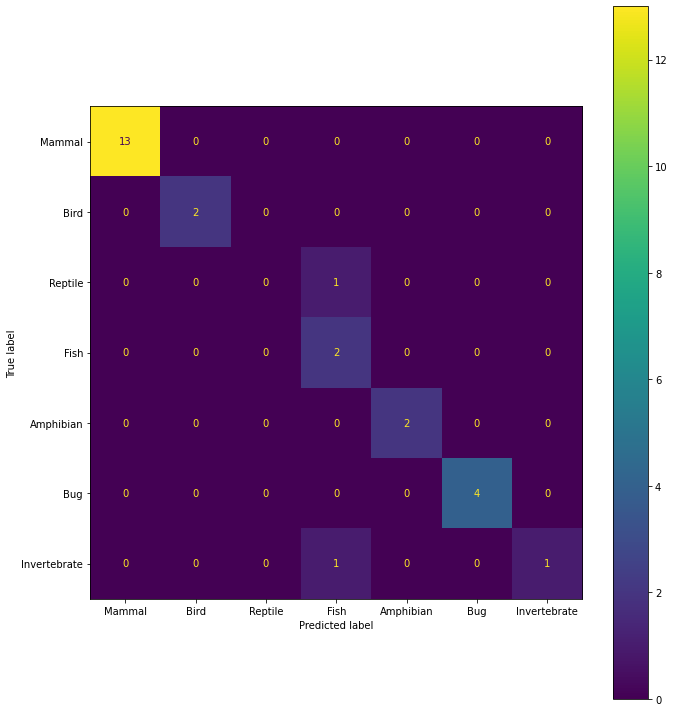

In [145]:
class_labels = [C[C.Class_Number == x].Class_Type.values[0] for x in sorted(K.priors.keys())]
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(ax=ax)
plt.tight_layout()
plt.show()

## Esercizio
L'implementazione contiene alcuni errori e bias che rendono l'algoritmo poco efficace. Revisionare il codice per sitemare gli errori. Osservare in particolare:
- Smooth: come gestire la probabilità 0 per una singola osservazione in modo che non annulli le altre
- Sbilanciamento del dataset: come possiamo allenare l'algoritmo a stimare le probabilità senza sovrastimare la classe più numerosa?

In [2]:
T = pd.read_csv('./data/zoo/zoo.csv')
K = pd.read_csv('./data/zoo/class.csv')

In [72]:
T.loc[11]

animal_name    chicken
hair                 0
feathers             1
eggs                 1
milk                 0
airborne             1
aquatic              0
predator             0
toothed              0
backbone             1
breathes             1
venomous             0
fins                 0
legs                 2
tail                 1
domestic             1
catsize              0
class_type           2
Name: 11, dtype: object

In [4]:
T_bool = T[[x for x in T.columns if x not in ['legs', 'animal_name']]]

In [5]:
legs_df = pd.get_dummies(T.legs, prefix='legs')

In [6]:
D = T_bool.join(legs_df)

In [7]:
def likelihood(class_name, feature):
    return (D[D.class_type==classname(
        class_name)][feature].sum() + 1) / (D[
        D.class_type==classname(class_name)].shape[0] +1)

In [8]:
class_dist = T.groupby('class_type').count()['animal_name']

In [9]:
def prior(x):
    return (class_dist / class_dist.sum()).loc[x]

classname = lambda name: K[K['Class_Type'] == name].Class_Number.values[0]
getname = lambda name: K[K['Class_Number'] == name].Class_Type.values[0]

In [10]:
likelihood('Mammal', 'legs_4')

0.7619047619047619

In [11]:
K

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


## Pre-processing

In [12]:
def extract_features(animal_index, df):
    features = []
    row = df.loc[animal_index]
    for k, v in row.items():
        if v > 0:
            features.append(k)
    return features

def get_class(animal_index, df):
    ctype = df.loc[animal_index].class_type
    return getname(ctype)

In [15]:
def predict(animal_i, klass):
    features = extract_features(animal_index=animal_i, df=D)
    p = 1.0
    for feature in features:
        p = p * likelihood(klass, feature)
    return prior(classname(klass)) * p

In [16]:
def read_prediction(animal):
    all_classes = np.array([predict(animal, k) for k in K.Class_Type.values])
    return K.Class_Type.values[all_classes.argmax()]

In [20]:
predictions = []
for animal in T.index.values:
    predictions.append({
        'animal': T.loc[animal].animal_name, 'real_class': get_class(animal, T),
        'prediction': read_prediction(animal)
    })
pred = pd.DataFrame(predictions)

In [22]:
pred

,animal,real_class,prediction
0,aardvark,Mammal,Mammal
1,antelope,Mammal,Mammal
2,bass,Fish,Fish
3,bear,Mammal,Mammal
4,boar,Mammal,Mammal
...,...,...,...
96,wallaby,Mammal,Mammal
97,wasp,Bug,Bug
98,wolf,Mammal,Mammal
99,worm,Invertebrate,Invertebrate


In [19]:
pd.get_dummies(T['legs'], prefix='legs')

,legs_0,legs_2,legs_4,legs_5,legs_6,legs_8
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
96,0,1,0,0,0,0
97,0,0,0,0,1,0
98,0,0,1,0,0,0
99,1,0,0,0,0,0


## Train and test

In [12]:
from collections import defaultdict

In [5]:
X_train, X_test, y_train, y_test = train_test_split(T[T.columns[:-1]], T.class_type, test_size=0.2, random_state=42)

In [14]:
cnt = defaultdict(lambda: 0)
for k, v in y_train.items():
    cnt[v] += 1

In [15]:
cnt

defaultdict(<function __main__.<lambda>()>,
            {5: 4, 6: 5, 1: 29, 7: 9, 2: 18, 3: 4, 4: 11})